## Traditional machine learning
Feature(s): SM-SMILES, Product-SMILES
- goal: predict the yield from a isomerisation; starting material and product are smiles.
- convert both to morgan fingerprints

target: yield_bin
- binary classification of yield

In [1]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

Read the dataset from the zip file

In [2]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'Isomerisation_train.csv'
csv_filename = 'Isomerisation_train.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)



In [3]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['yield_bin']
Features = ['SM-SMILES', 'Product-SMILES']
Feature_types = ['SMILES', 'SMILES']
input = df

In [4]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [5]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [10]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 3, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=2,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



[I 2024-10-18 09:37:37,525] A new study created in memory with name: no-name-a238302e-ac07-43bf-821c-7dddba4e4c4c
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:37,655] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 63, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.6.


RUN: Model:RandomForestClassifier / Target:['yield_bin'] / Train size:10 / Seed:1


/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:38,232] Trial 1 finished with value: 0.4 and parameters: {'n_estimators': 234, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6.
[I 2024-10-18 09:37:38,274] A new study created in memory with name: no-name-28bdf840-aa15-4359-9980-f47d6714fe45
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:38,439] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 117, 'max_depth': 8, 'learning_rate': 0.039277233980323796, 'subsample': 0.8364311214661199, 'colsample_bytree': 0.8686665865344205, 'ga

RUN: Model:XGBClassifier / Target:['yield_bin'] / Train size:10 / Seed:1


/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:38,735] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.05967537379294041, 'subsample': 0.8298740272079682, 'colsample_bytree': 0.7246691483492174, 'gamma': 2.6272515482255982e-08, 'reg_alpha': 7.835507489950758e-05, 'reg_lambda': 1.2850433796691709e-05}. Best is trial 0 with value: 0.6.
[I 2024-10-18 09:37:38,787] A new study created in memory with name: no-name-888da21a-499a-4e8c-8114-90c317c256fe
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


RUN: Model:RandomForestClassifier / Target:['yield_bin'] / Train size:10 / Seed:2


[I 2024-10-18 09:37:39,195] Trial 0 finished with value: 0.4 and parameters: {'n_estimators': 169, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.4.
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:39,353] Trial 1 finished with value: 0.4 and parameters: {'n_estimators': 83, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.4.
[I 2024-10-18 09:37:39,452] A new study created in memory with name: no-name-a06b55c8-0cab-41ee-a1ba-9f21a88ef4e5
/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warning

RUN: Model:XGBClassifier / Target:['yield_bin'] / Train size:10 / Seed:2


/home/jorenvanherck/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 09:37:39,804] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate': 0.015189149666890353, 'subsample': 0.8913767181066719, 'colsample_bytree': 0.7973830110263214, 'gamma': 0.047235466672129314, 'reg_alpha': 4.1747675532434636e-05, 'reg_lambda': 1.6246751008986245e-08}. Best is trial 0 with value: 0.6.
[I 2024-10-18 09:37:39,853] A new study created in memory with name: no-name-5accec53-6d64-4c40-bcb0-6bf4cbecb942


RUN: Model:RandomForestClassifier / Target:['yield_bin'] / Train size:10 / Seed:3


[I 2024-10-18 09:37:40,322] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 251, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.5.
[I 2024-10-18 09:37:40,942] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 256, 'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.5.
[I 2024-10-18 09:37:41,053] A new study created in memory with name: no-name-955ffc57-c370-4e0d-ada0-3a6418d3bf5a
[I 2024-10-18 09:37:41,143] Trial 0 finished with value: 0.7 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.13215773581893375, 'subsample': 0.8734443760813095, 'colsample_bytree': 0.5940307422707679, 'gamma': 2.0545006167582196e-05, 'reg_alpha': 0.19996409937085954, 'reg_lambda': 0.08313521541000853}. Best is trial 0 with value: 0.7.
[I 2024-10-18 09:37:41,200] Trial 1 fini

RUN: Model:XGBClassifier / Target:['yield_bin'] / Train size:10 / Seed:3


Some information about the dataset such as the splitting, wrong smiles, total number of samples.

In [6]:
df = pd.DataFrame(result)
display(df)
df.to_csv('Yield_isomerisation_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[yield_bin],10,"[0, 0, 1]","[0, 0, 0]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.666667,0.666667,0.400000,0.0,1
1,XGBClassifier,[yield_bin],10,"[0, 0, 1]","[0, 1, 1]","{'objective': 'binary:logistic', 'use_label_en...",0.666667,0.666667,0.666667,0.4,1
2,RandomForestClassifier,[yield_bin],10,"[1, 0, 1]","[1, 1, 1]","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.666667,0.666667,0.400000,0.0,2
3,XGBClassifier,[yield_bin],10,"[1, 0, 1]","[0, 1, 1]","{'objective': 'binary:logistic', 'use_label_en...",0.333333,0.333333,0.250000,-0.5,2
4,RandomForestClassifier,[yield_bin],10,"[1, 1, 0]","[0, 0, 0]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.333333,0.333333,0.250000,0.0,3
5,XGBClassifier,[yield_bin],10,"[1, 1, 0]","[0, 1, 0]","{'objective': 'binary:logistic', 'use_label_en...",0.666667,0.666667,0.666667,0.4,3


Text(0.5, 0.98, 'Random Forrest & XGB - Yield_isomerisation')

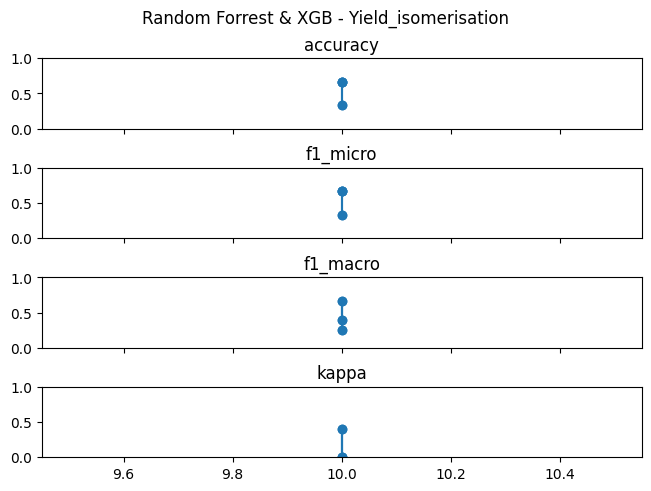

In [7]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest & XGB - Yield_isomerisation')